# Draft of HW 6 / final midterm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mnist import MNIST
from sklearn import linear_model


In [2]:
file_dir = '/Users/jmnugent/Documents/__Year_3_2020-2021/AMATH_584-Numerical_Linear_Algebra/Homework/python/amath584/hw6_regression_and_sparsity/'
data_dir = file_dir + 'data/'
save_dir = file_dir + 'figures/'


### Load in the MNIST data
This method comes from https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python and uses the **python-mnist** package (documentation here: https://pypi.org/project/python-mnist/).

In [3]:
# there are 60000 items in each training object
# and 10000 in the testing

mndata = MNIST('data')

train_imgs, train_labs = mndata.load_training()
test_imgs, test_labs = mndata.load_testing()

# the imgs are now arrays of arrays of integers for each picture
# the labels are now numpy arrays
train_imgs = np.asarray(train_imgs)
test_imgs = np.asarray(test_imgs)
train_labs = np.asarray(train_labs)
test_labs = np.asarray(test_labs)


In [4]:
# check out the sizes
for x in [train_imgs, train_labs, test_imgs, test_labs]:
    print(x.shape)
    

(60000, 784)
(60000,)
(10000, 784)
(10000,)


#### Vectorize and reshape the MNIST images to make the matrix A
* B = [$y_1$, $y_2$, ..., $y_n$], which is the set of output (column) vectors; [0, ..., 0, 1] for 0, [1, 0, ..., 0] for 1, [0, 1, 0, ..., 0] for 2, etc.
    * these are the LABELS!

    
* X = [$x_1$, $x_2$, ..., $x_n$], where each $x_n$ is a vector reshaped from an nxn image
    * here, this is 28x28 such that each image has 784 entries
    * these are the IMAGES!

In [39]:
# get the size and dimensions for each picture (n x n)
ntrain, n2 = train_imgs.shape
n = int(np.sqrt(n2)) 
ntest = test_imgs.shape[0]


##### Need to turn the list of labels into vectors

In [40]:
def convert_label(label):
    """Convert an integer label (0-9) into a vector.
    """
    vector = np.zeros(10)
    vector[label-1] = 1

    return vector


In [41]:
def reshape_pic(array, n=28):
    """Reshaped input array into nxn array
    """
    new = np.reshape(array, (n, n))
    
    return new


In [360]:
def set_label(vec):
    """
    Assigns the 0-9 label to the label vector based on which
    entry has the largest magnitude.
    """
    ind = np.where(np.abs(vec) == np.max(np.abs(vec)))[0][0]
    if ind == 9:
        label = 0
    else:
        label = ind+1
    
    return label
    

In [ ]:
def count_correct(vecs, labels):
    """
    
    """

In [45]:
B_train = np.zeros((ntrain, 10))
B_test = np.zeros((ntest, 10))

for i in range(ntrain):
    B_train[i, :] = convert_label(train_labs[i])

for i in range(ntest):
    B_test[i, :] = convert_label(test_labs[i])
    

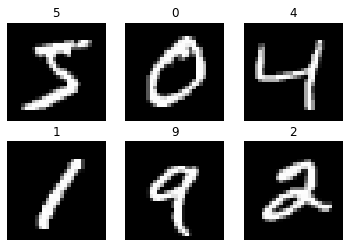

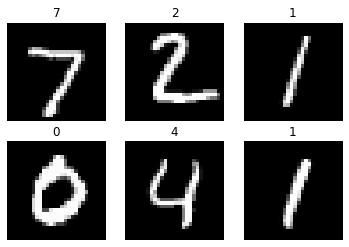

In [55]:
# plot the first few to see how they look

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(reshape_pic(train_imgs[i]), cmap='gray')
    ax.set_title(train_labs[i])
    ax.axis('off')
    
plt.show()

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(reshape_pic(test_imgs[i]), cmap='gray')
    ax.set_title(test_labs[i])
    ax.axis('off')
    
plt.show()



##### Check the shapes!
Should get A = (60,000 x 784), _x = (784 x 10)_, 
and B = (60,000 x 10)

* **A**: each row is an image and each column is a pixel
* **B**: each row is an image and each column is its label (0 or 1)
* **x**: THE WEIGHTS!!! eaach row is a pixel and each column is how much it should be weighted for that number

In [54]:
print(train_imgs.shape)
print(B_train.shape, '\n')

print(test_imgs.shape)
print(B_test.shape)

(60000, 784)
(60000, 10) 

(10000, 784)
(10000, 10)


# 1. Using various AX=B solvers, determine a mapping from the image space to the label space
As done in the lecture, let's try this for 4 things:
* (a) pinv (least squares) (np.linalg.pinv(A))
* (b-d) lasso with varying alpha (linear_model.Lasso())
* (e) ridge (linear_model.Ridge())

##### Error vs. model (box plots)
Try the number of wrong labels for each type? --> but I think that'd be better for the digit-only stuff??

##### Count the number right/wrong
Use this to make a bar plot to compare accuracy of all the methods

In [373]:
def check_accuracy(labels, truth):
    """
    Returns the number of correct and incorrect labels.
        labels = 2D matrix of size (10, #samples) of the modeled labels
        truth = 1D list of the actual labels (0-9)
    Ex: [n_right, n_wrong] = check_accuracy(lasso_labs, test_labs)
    """
    n_right = 0
    n_wrong = 0
    
    for i in range(labels.shape[1]):
        error = set_label(labels[:, i]) - truth[i]
        if error == 0:
            n_right += 1
        else:
            n_wrong += 1
            
    return [n_right, n_wrong]


##### Bar plot of the loadings/coeff of matrix A (all 784)

In [317]:
def plot_loadings_bar(A, method, name, n=28, save=False,
                      save_dir=save_dir):
    """
    Bar plot of the loadings for each digit
    
        A = matrix of weights (10xn^2)
        method = method name (e.g. 'Lasso (alpha=0.1)')
        name = name for the file to save (e.g. 'lasso_01')
        n = dimension of picture in each direction (default=28 pixels)
        save = True if you want to save the image
        save_dir = directory to save the file to
    """
    if A.shape != (10, n**2):
        raise Exception('Weight matrix A has incorrect dimensions: {}'.format(A.shape))
    
    fig, axes = plt.subplots(2, 5, figsize=(18, 5))
    plt.subplots_adjust(hspace=0.5)
    
    for r in range(2):
        for c in range(5):
            ax = axes[r, c]
            
            if r == 0:
                i = c
            else:
                i = c+5
        
            ax.bar(np.arange(0, n**2), A[i, :].flatten())
            ax.axhline(0, linewidth=1, alpha=0.25, color='k')

            if i == 9:
                ax.set_title('0')
            else:
                ax.set_title(str(i+1))

            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])

    plt.suptitle(method, fontsize=18)
    
    if save:
        plt.savefig(save_dir + 'bar_plot_loadings_' + name + '.png', dpi=300,
                    bbox_inches='tight')
    
    plt.show()


###### Plot the weights/loadings/mapping for that method:
(Should give an idea of what the most important pixels are/what feeatures it's looking at to make a classification decision):

In [331]:
def plot_weights(A, method, name, n=28, save=False, no_zero=False, save_dir=save_dir):
    """
    Plot (and save) the weighhts for each method.
    
        A = matrix of weights (10xn^2)
        method = method name (e.g. 'Lasso (alpha=0.1)')
        name = name for the file to save (e.g. 'lasso_01')
        n = dimension of picture in each direction (default=28 pixels)
        save = True if you want to save the image
        no_zero = plot by omitting zeros (to see sparsity)
        save_dir = directory to save the file to
    """
    if A.shape != (10, n**2):
        raise Exception('Weight matrix A has incorrect dimensions: {}'.format(A.shape))
    
    if no_zero:
        A = np.where(A==0, np.nan, A)
        name += '_no_zeros'
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 4))

    for r in range(2):
        for c in range(5):
            ax = axes[r, c]
            
            if r == 0:
                i = c
            else:
                i = c+5
        
            ax.set_aspect('equal')
            ax.pcolormesh(reshape_pic(A[i, :], n=n), cmap='gray')
        
            if i == 9:
                ax.set_title('0')
            else:
                ax.set_title(str(i+1))

            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])

    plt.suptitle(method)
    
    if save:
        plt.savefig(save_dir + 'weight_matrix_' + name + '.png', dpi=300,
                    bbox_inches='tight')
    plt.show()


##### Plot a histogram of nonzero weight values
Another way to get a sense of sparsity and the values of the weights for pixels that are the most important

In [455]:
def plot_hist_nonzero(A, method, name, save=False, save_dir=save_dir,
                      xlim=(-.02, .02)):
    """
    Plot (and save) a histogram of the aboslute value of nonzero points of the matrix.
    
        A = matrix of weights (10xn^2)
        method = method name (e.g. 'Lasso (alpha=0.1)')
        name = name for the file to save (e.g. 'lasso_01')
        save = True if you want to save the image
        save_dir = directory to save the file to
        xlim = limits on x axis (default=(-.02, .02), for pinv)
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 4))
    plt.subplots_adjust(hspace=0.6, wspace=0.4)
    
    for r in range(2):
        for c in range(5):
            ax = axes[r, c]
            
            if r == 0:
                i = c
            else:
                i = c+5
                
            flat = A[i, :].flatten()
            nonzero = flat[flat != 0.0]
            ax.hist(nonzero, bins=100)
            
            ax.set_yscale('log')
            ax.set_ylim((1, 1000))
            ax.set_xlim(xlim)
        
            if i == 9:
                ax.set_title('0')
            else:
                ax.set_title(str(i+1))

    plt.suptitle('Histogram of nonzero loadings ({})'.format(method))
    
    if save:
        plt.savefig(save_dir + 'nonzero_hist_' + name + '.png', dpi=300,
                    bbox_inches='tight')

    plt.show()    


### (a) pinv
Example from the data book:
    
    A = label @ np.linalg.pinv(train)
    test_labels = np.sign(A@test)

In [377]:
A_pinv = B_train.T @ np.linalg.pinv(train_imgs.T)
pinv_labs = A_pinv @ test_imgs.T


In [382]:
# how accurate was it?

[pinv_corr, pinv_wrong] = check_accuracy(pinv_labs, test_labs)

print(str(pinv_corr/(pinv_corr+pinv_wrong)*100.) + '% correct')


85.25% correct


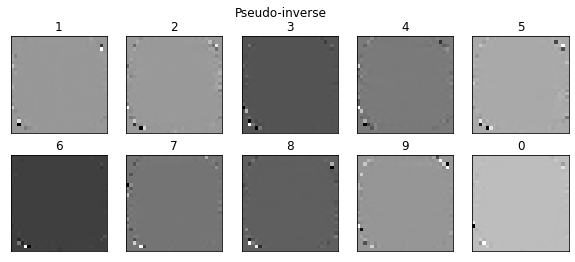

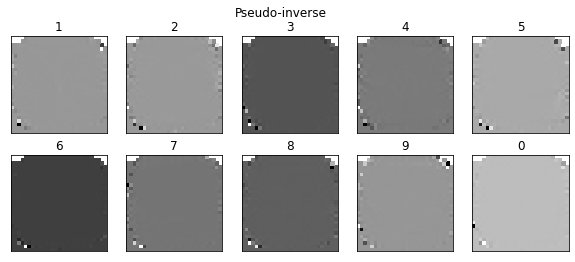

In [270]:
# check out what the weights look like - should show you 
# the important pixels!

plot_weights(A_pinv, 'Pseudo-inverse', 'pinv', save=True)
plot_weights(A_pinv, 'Pseudo-inverse', 'pinv', no_zero=True, save=True)


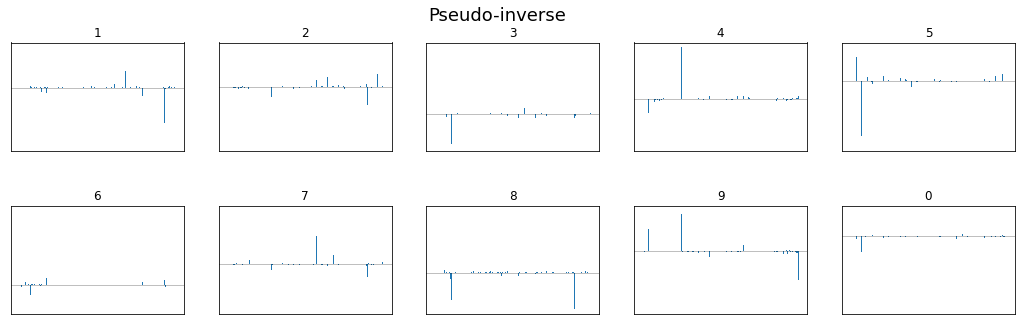

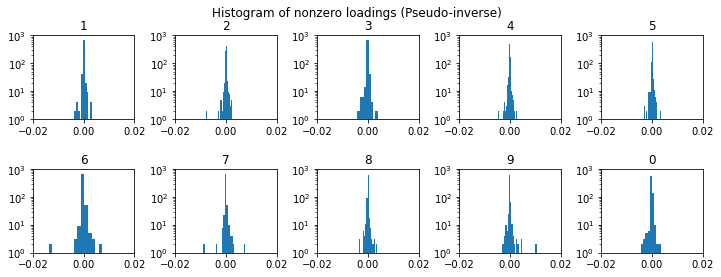

In [461]:
# some accuracy plots, etc...

plot_loadings_bar(A_pinv, 'Pseudo-inverse', 'pinv', save=True)
plot_hist_nonzero(A_pinv, 'Pseudo-inverse', 'pinv', save=True)


### (b) Lasso, alpha=1.0
Example from the data book:

    lasso = linear_model.Lasso().fit(train.T,label)
    A_lasso = lasso.coef_
    test_labels_lasso = np.sign(A_lasso@test)

In [128]:
lasso = linear_model.Lasso().fit(train_imgs, B_train)
A_lasso = lasso.coef_
lasso_labs_1 = A_lasso @ test_imgs.T


In [385]:
# how accurate was it?

[lasso1_corr, lasso1_wrong] = check_accuracy(lasso_labs_1, test_labs)

print(str(lasso1_corr/(lasso1_corr+lasso1_wrong)*100.) + '% correct')


74.48% correct


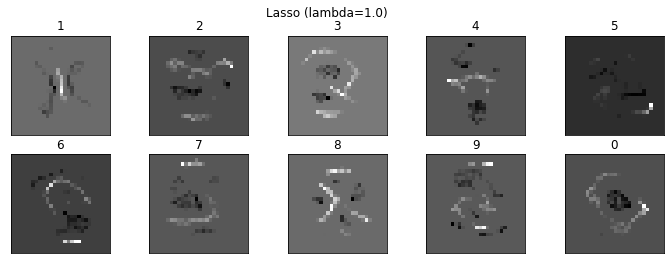

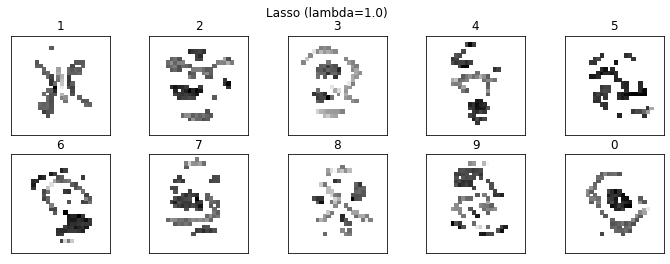

In [332]:
# check out what the weights look like - should show you 
# the important pixels!

plot_weights(A_lasso, 'Lasso (lambda=1.0)', 'lasso_1', save=True)
plot_weights(A_lasso, 'Lasso (lambda=1.0)', 'lasso_1', no_zero=True, save=True)


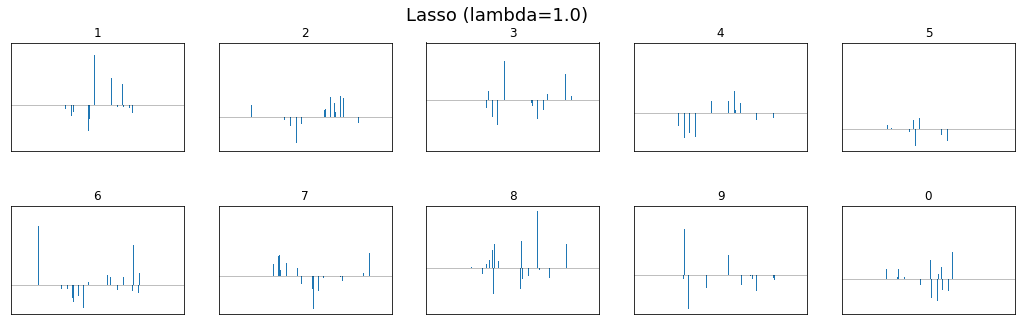

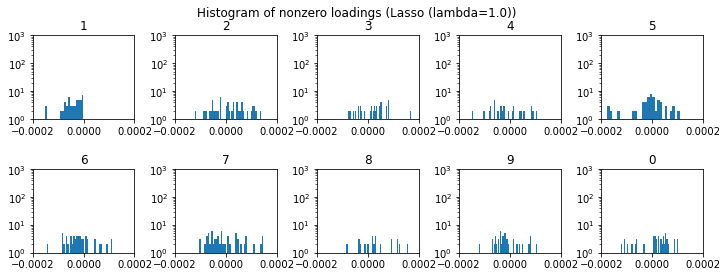

In [462]:
# some accuracy plots, etc...

plot_loadings_bar(A_lasso, 'Lasso (lambda=1.0)', 'lasso_1', save=True)
plot_hist_nonzero(A_lasso, 'Lasso (lambda=1.0)', 'lasso_1', xlim=(-2e-4, 2e-4),
                  save=True)


### (c) Lasso, alpha = 0.5
This is a lower weight for the L1 term than above. Solution should be LESS sparse.

In [152]:
lasso_05 = linear_model.Lasso(alpha=0.5).fit(train_imgs, B_train)
A_lasso_05 = lasso_05.coef_
lasso_labs_05 = A_lasso_05 @ test_imgs.T


In [386]:
# how accurate was it?

[lasso05_corr, lasso05_wrong] = check_accuracy(lasso_labs_05, test_labs)

print(str(lasso05_corr/(lasso05_corr+lasso05_wrong)*100.) + '% correct')


75.98% correct


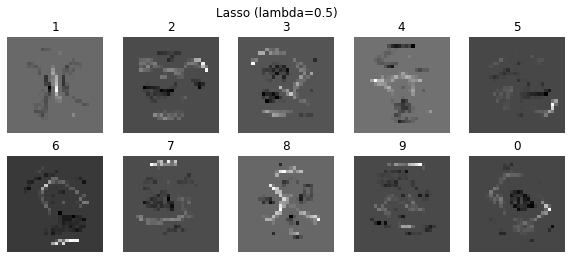

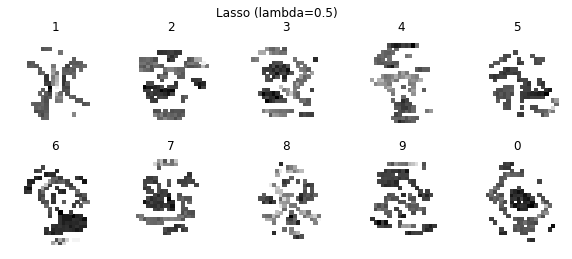

In [225]:
# check out what the weights look like - should show you 
# the important pixels!

plot_weights(A_lasso_05, 'Lasso (lambda=0.5)', 'lasso_05', save=True)
plot_weights(A_lasso_05, 'Lasso (lambda=0.5)', 'lasso_05', no_zero=True, save=True)


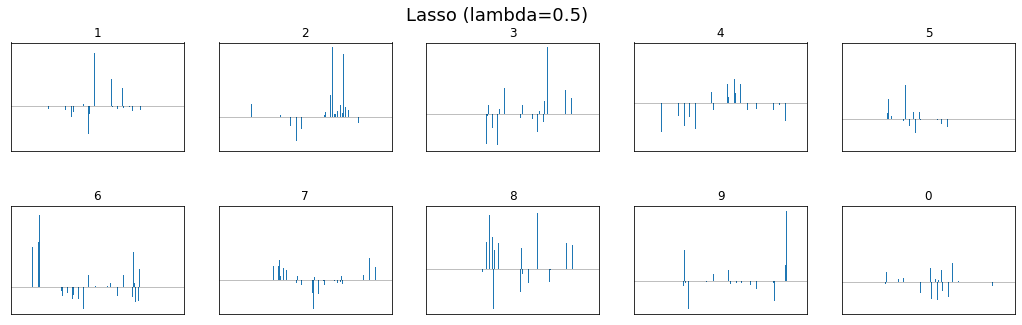

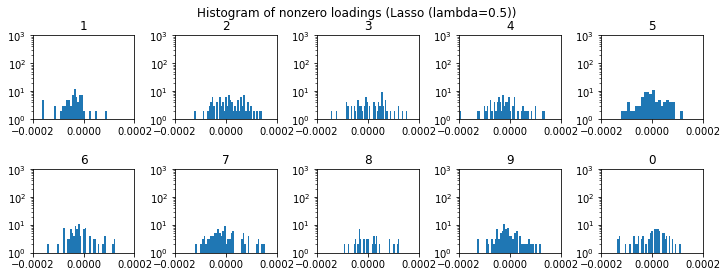

In [463]:
# some accuracy plots, etc...

plot_loadings_bar(A_lasso_05, 'Lasso (lambda=0.5)', 'lasso_05', save=True)
plot_hist_nonzero(A_lasso_05, 'Lasso (lambda=0.5)', 'lasso_05', xlim=(-2e-4, 2e-4),
                  save=True)


### (d) Lasso, alpha = 0.1
Even less of a weight on L1. Should be similar to the linear regression (pinv)

In [157]:
lasso_01 = linear_model.Lasso(alpha=0.1).fit(train_imgs, B_train)
A_lasso_01 = lasso_01.coef_
lasso_labs_01 = A_lasso_01 @ test_imgs.T


In [387]:
# how accurate was it?

[lasso01_corr, lasso01_wrong] = check_accuracy(lasso_labs_01, test_labs)

print(str(lasso01_corr/(lasso01_corr+lasso01_wrong)*100.) + '% correct')


77.71000000000001% correct


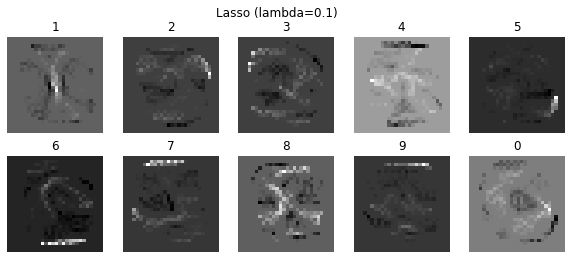

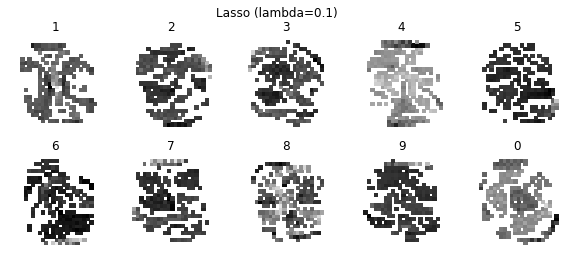

In [226]:
# check out what the weights look like - should show you 
# the important pixels!

plot_weights(A_lasso_01, 'Lasso (lambda=0.1)', 'lasso_01', save=True)
plot_weights(A_lasso_01, 'Lasso (lambda=0.1)', 'lasso_01', no_zero=True, save=True)


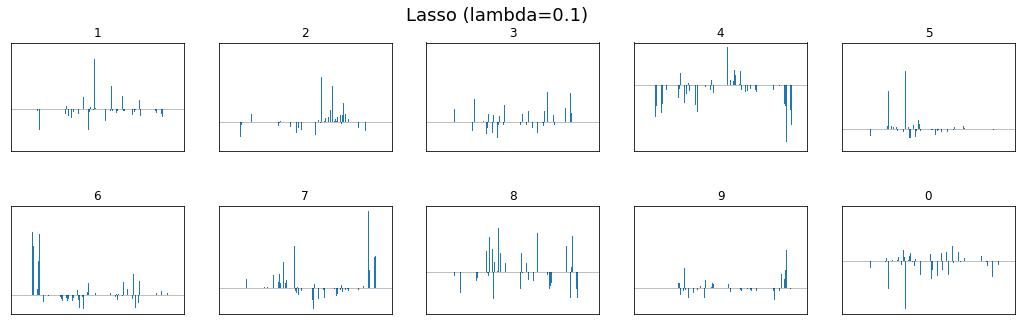

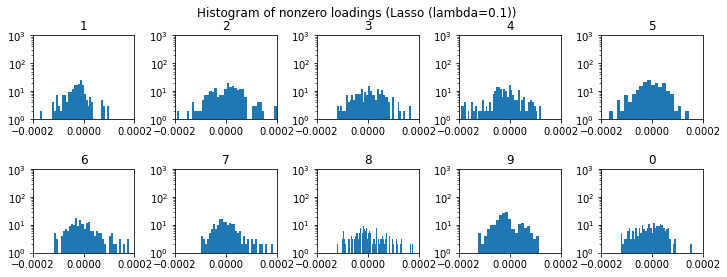

In [464]:
# some accuracy plots, etc...

plot_loadings_bar(A_lasso_01, 'Lasso (lambda=0.1)', 'lasso_01', save=True)
plot_hist_nonzero(A_lasso_01, 'Lasso (lambda=0.1)', 'lasso_01', xlim=(-2e-4, 2e-4),
                  save=True)


### (e) Ridge
"Linear least squares with L2 regularization"
    

In [122]:
# ridge = linear_model.Ridge().fit(train_imgs, train_labs)
ridge = linear_model.Ridge().fit(train_imgs, B_train)
A_ridge = ridge.coef_
ridge_labs = A_ridge @ test_imgs.T


In [388]:
# how accurate was it?

[ridge_corr, ridge_wrong] = check_accuracy(ridge_labs, test_labs)

print(str(ridge_corr/(ridge_corr+ridge_wrong)*100.) + '% correct')


77.62% correct


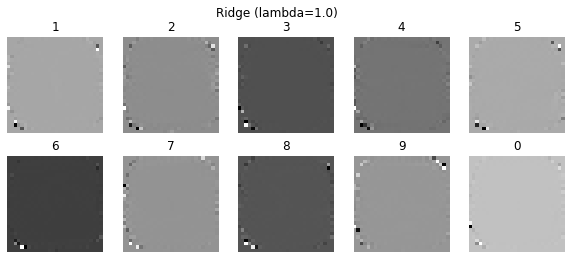

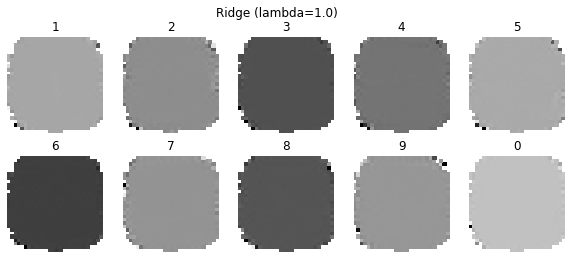

In [227]:
# check out what the weights look like - should show you 
# the important pixels!

plot_weights(A_ridge, 'Ridge (lambda=1.0)', 'ridge', save=True)
plot_weights(A_ridge, 'Ridge (lambda=1.0)', 'ridge', no_zero=True, save=True)


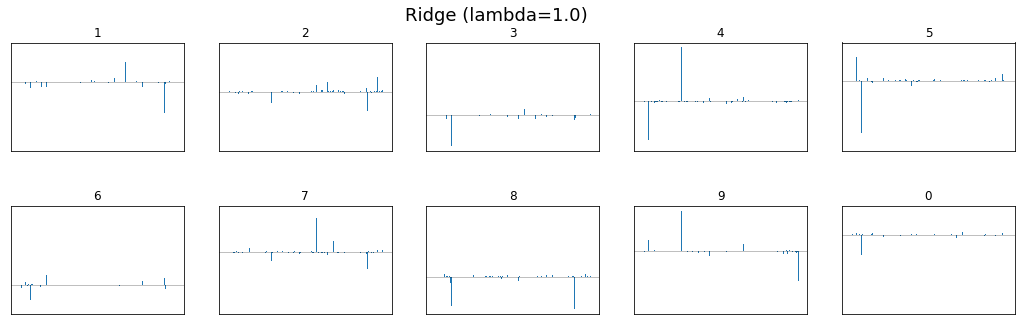

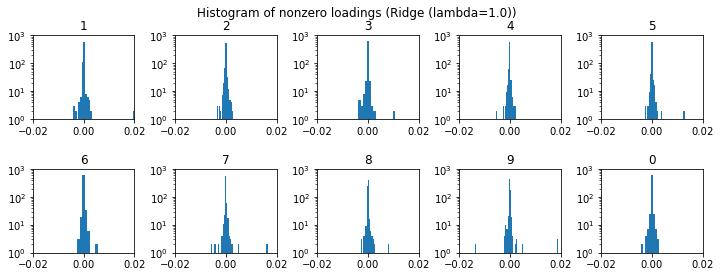

In [467]:
# some accuracy plots, etc...

plot_loadings_bar(A_ridge, 'Ridge (lambda=1.0)', 'ridge', save=True)
plot_hist_nonzero(A_ridge, 'Ridge (lambda=1.0)', 'ridge', save=True)


# 2. By promoting sparsity, determine and rank which pixels in the MNIST set are most informative for correctly labeling the digits.
(You’ll have to come up with your own heuristics or empirical rules for this. Use pcolor to help you visualize the results from X)

##### Look at overall accuracy
This kind of falls under #1, but whatever...

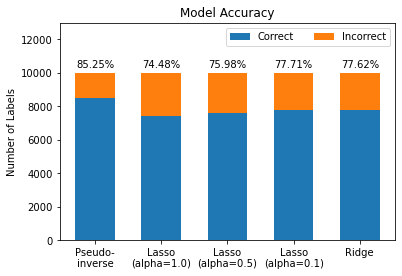

In [427]:
fig, ax = plt.subplots(figsize=(6, 4))

corr_counts = [pinv_corr, lasso1_corr, lasso05_corr, lasso01_corr, ridge_corr]
wrong_counts = [pinv_wrong, lasso1_wrong, lasso05_wrong, lasso01_wrong, ridge_wrong]

inds = np.arange(len(corr_counts))
width = 0.6

rects1 = ax.bar(inds, corr_counts, width, color='C0')
rects2 = ax.bar(inds, wrong_counts, width, bottom=corr_counts, color='C1')

ax.set_xticks(np.arange(0, len(corr_counts)))
ax.set_xticklabels(['Pseudo-\ninverse', 'Lasso\n(alpha=1.0)', 'Lasso\n(alpha=0.5)',
                    'Lasso\n(alpha=0.1)', 'Ridge'])

ax.set_ylabel('Number of Labels')
plt.legend([rects1[0], rects2[0]], ['Correct', 'Incorrect'], loc='upper right', ncol=2)
ax.set_title('Model Accuracy')
ax.set_ylim(0, 13000)


# label for accuracy
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
accuracy = [(corr_counts[i]/(corr_counts[i]+wrong_counts[i]))*100. for i in range(len(corr_counts))]
accuracy_labs = ['{:.2f}%'.format(x) for x in accuracy]
for i in range(len(rects2)):
    height = rects1[i].get_height() + rects2[i].get_height()
    ax.annotate(accuracy_labs[i],
                xy=(rects2[i].get_x() + rects2[i].get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

plt.savefig(save_dir + 'all_data_accuracy_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


###### Look at sparsity 
(but none of this is surprising! This is exactly what you'd expect based on the behavior of each regularizer)
(and what you can see from the plots above!!)

In [186]:
def num_zeros(A):
    """ Print number of zero weights for each digit
    """
    num_zeros = np.zeros(10)
    for i in range(10):
        num_zeros[i] = len(A[i, :][A[i, :] == 0])
    
    print(num_zeros)
    

In [187]:
# from most to least sparse:

num_zeros(A_lasso)
num_zeros(A_lasso_01)
num_zeros(A_lasso_05)
num_zeros(A_ridge)
num_zeros(A_pinv)


[710. 687. 697. 711. 712. 697. 690. 708. 696. 699.]
[565. 552. 560. 536. 575. 562. 562. 566. 554. 550.]
[685. 649. 661. 662. 675. 656. 657. 672. 658. 664.]
[67. 67. 67. 67. 67. 67. 67. 67. 67. 67.]
[14. 14. 14. 14. 14. 14. 14. 14. 14. 14.]


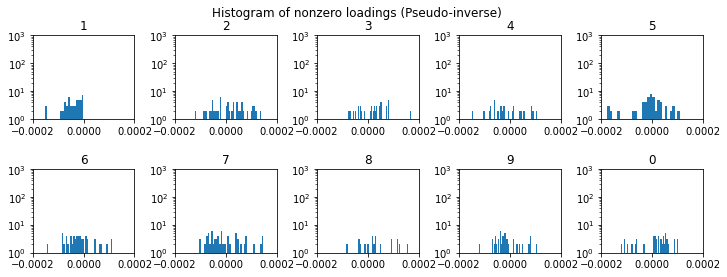

# TODO:


2. Histogram of the frequency of abs of nonzero points? So you can visualize a good "cutoff" for the value of a weight to be worth keeping...
    * use this to FIGURE OUT WHERE TO CUT I
    * once you do that, plot what A looks like if those are (zeroed out? nans?)
    * ...and then try a reconstruction or something>sf.d.f,.sdf,?? idk... another way to test accuracy
    * **other "heuristics"?**
        * maybe a plot of increasing error/accuracy/something as the number of pixels goes up??? I have NO IDEA
        
Does the intercept value matter? Someone mentioned that...

3. ONCE YOU DO ALL THAT for the whole thing, repeat for each digit by picking the specific pixels/values that matter for that digit (I think?)
    * I think you could repeat the above, but just picking a tighter cutoff maybe? So like instead of a blanket 100 pixels or whatever it might be 50 for 1, 100 for 4, 200 for 8, etc.?


4. BOTTOM LINE: MAKE SURE YOU HAVE SOME KIND OF # INCORRECT GUESSES PLOT!!!
    * would be really good to plot a few random testing numbers and label them with how your algorithm classified them??

# 3. Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.

# 4. Redo the analysis with each digit individually to find the most important pixels for each digit.

# 5. IMPORTANT: Think about the interpretation of what you are doing with this AX = B problem.
(I think you'll just write something about interpreting the results...)